In [36]:
import numpy as np
from pathlib import Path
import h5py
import math
import time
from datetime import datetime
from tqdm import tqdm
import pandas as pd
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

import rerf
from rerf.rerfClassifier import rerfClassifier

from graspy.plot import heatmap

from simulations import get_2class_sbms

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [37]:
def sort_keep_balance(y,block_lengths):
    """
    Sort data and labels into blocks that preserve class balance
    
    Parameters
    ----------
    X: data matrix
    y : 1D class labels
    block_lengths : Block sizes to sort X,y into that preserve class balance
    """
    clss,counts = np.unique(y, return_counts=True)
    ratios = counts / sum(counts)
    class_idxs = [np.where(y==i)[0] for i in clss]

    sort_idxs = []
    
    prior_idxs = np.zeros(len(clss)).astype(int)
    for n in block_lengths:
        get_idxs = np.rint(n*ratios).astype(int)
        for idxs,prior_idx,next_idx in zip(class_idxs,prior_idxs,get_idxs):
            sort_idxs.append(idxs[prior_idx:next_idx])
        prior_idxs = get_idxs
        
    sort_idxs = np.hstack(sort_idxs)
    
    return(sort_idxs)

In [58]:
X_train,y_train = get_2class_sbms(n=200)
X_test,y_test = get_2class_sbms(n=500)

ns = [10,50,100,200]

In [59]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

In [65]:
# Parameters
n_est = 100
ncores = 20
max_features = 'auto'#int(math.sqrt(X.shape[1])/2)
HEIGHT = int(np.sqrt(X_train.shape[1]))
WIDTH = HEIGHT
wmax = 10
wmin = 10

In [66]:
names = {"RF":"#f86000", "GORF":"red"}
classifiers = [RandomForestClassifier(n_estimators=n_est, max_features='auto', n_jobs=ncores),
               rerfClassifier(
                    projection_matrix="Graph", 
                    max_features=max_features,
                    n_estimators=n_est,
                    n_jobs=ncores,
                    image_height=HEIGHT, 
                    image_width=WIDTH, 
                    patch_width_max=wmax,
                    patch_width_min=wmin
                ),]

In [67]:
runList = [(n, clf, name) for n in ns\
           for clf,name in zip(classifiers, [name for name in names])]

In [68]:
run_data = []
for n, clf, name in tqdm(runList):
    trainStartTime = time.time()
    clf.fit(X_train[:n], y_train[:n])
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    testStartTime = time.time()
    yhat = clf.predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    lhat = np.mean(np.not_equal(yhat, y_test).astype(int))

    run_data.append([name, n, lhat, trainTime, testTime])

100%|██████████| 8/8 [00:02<00:00,  3.35it/s]


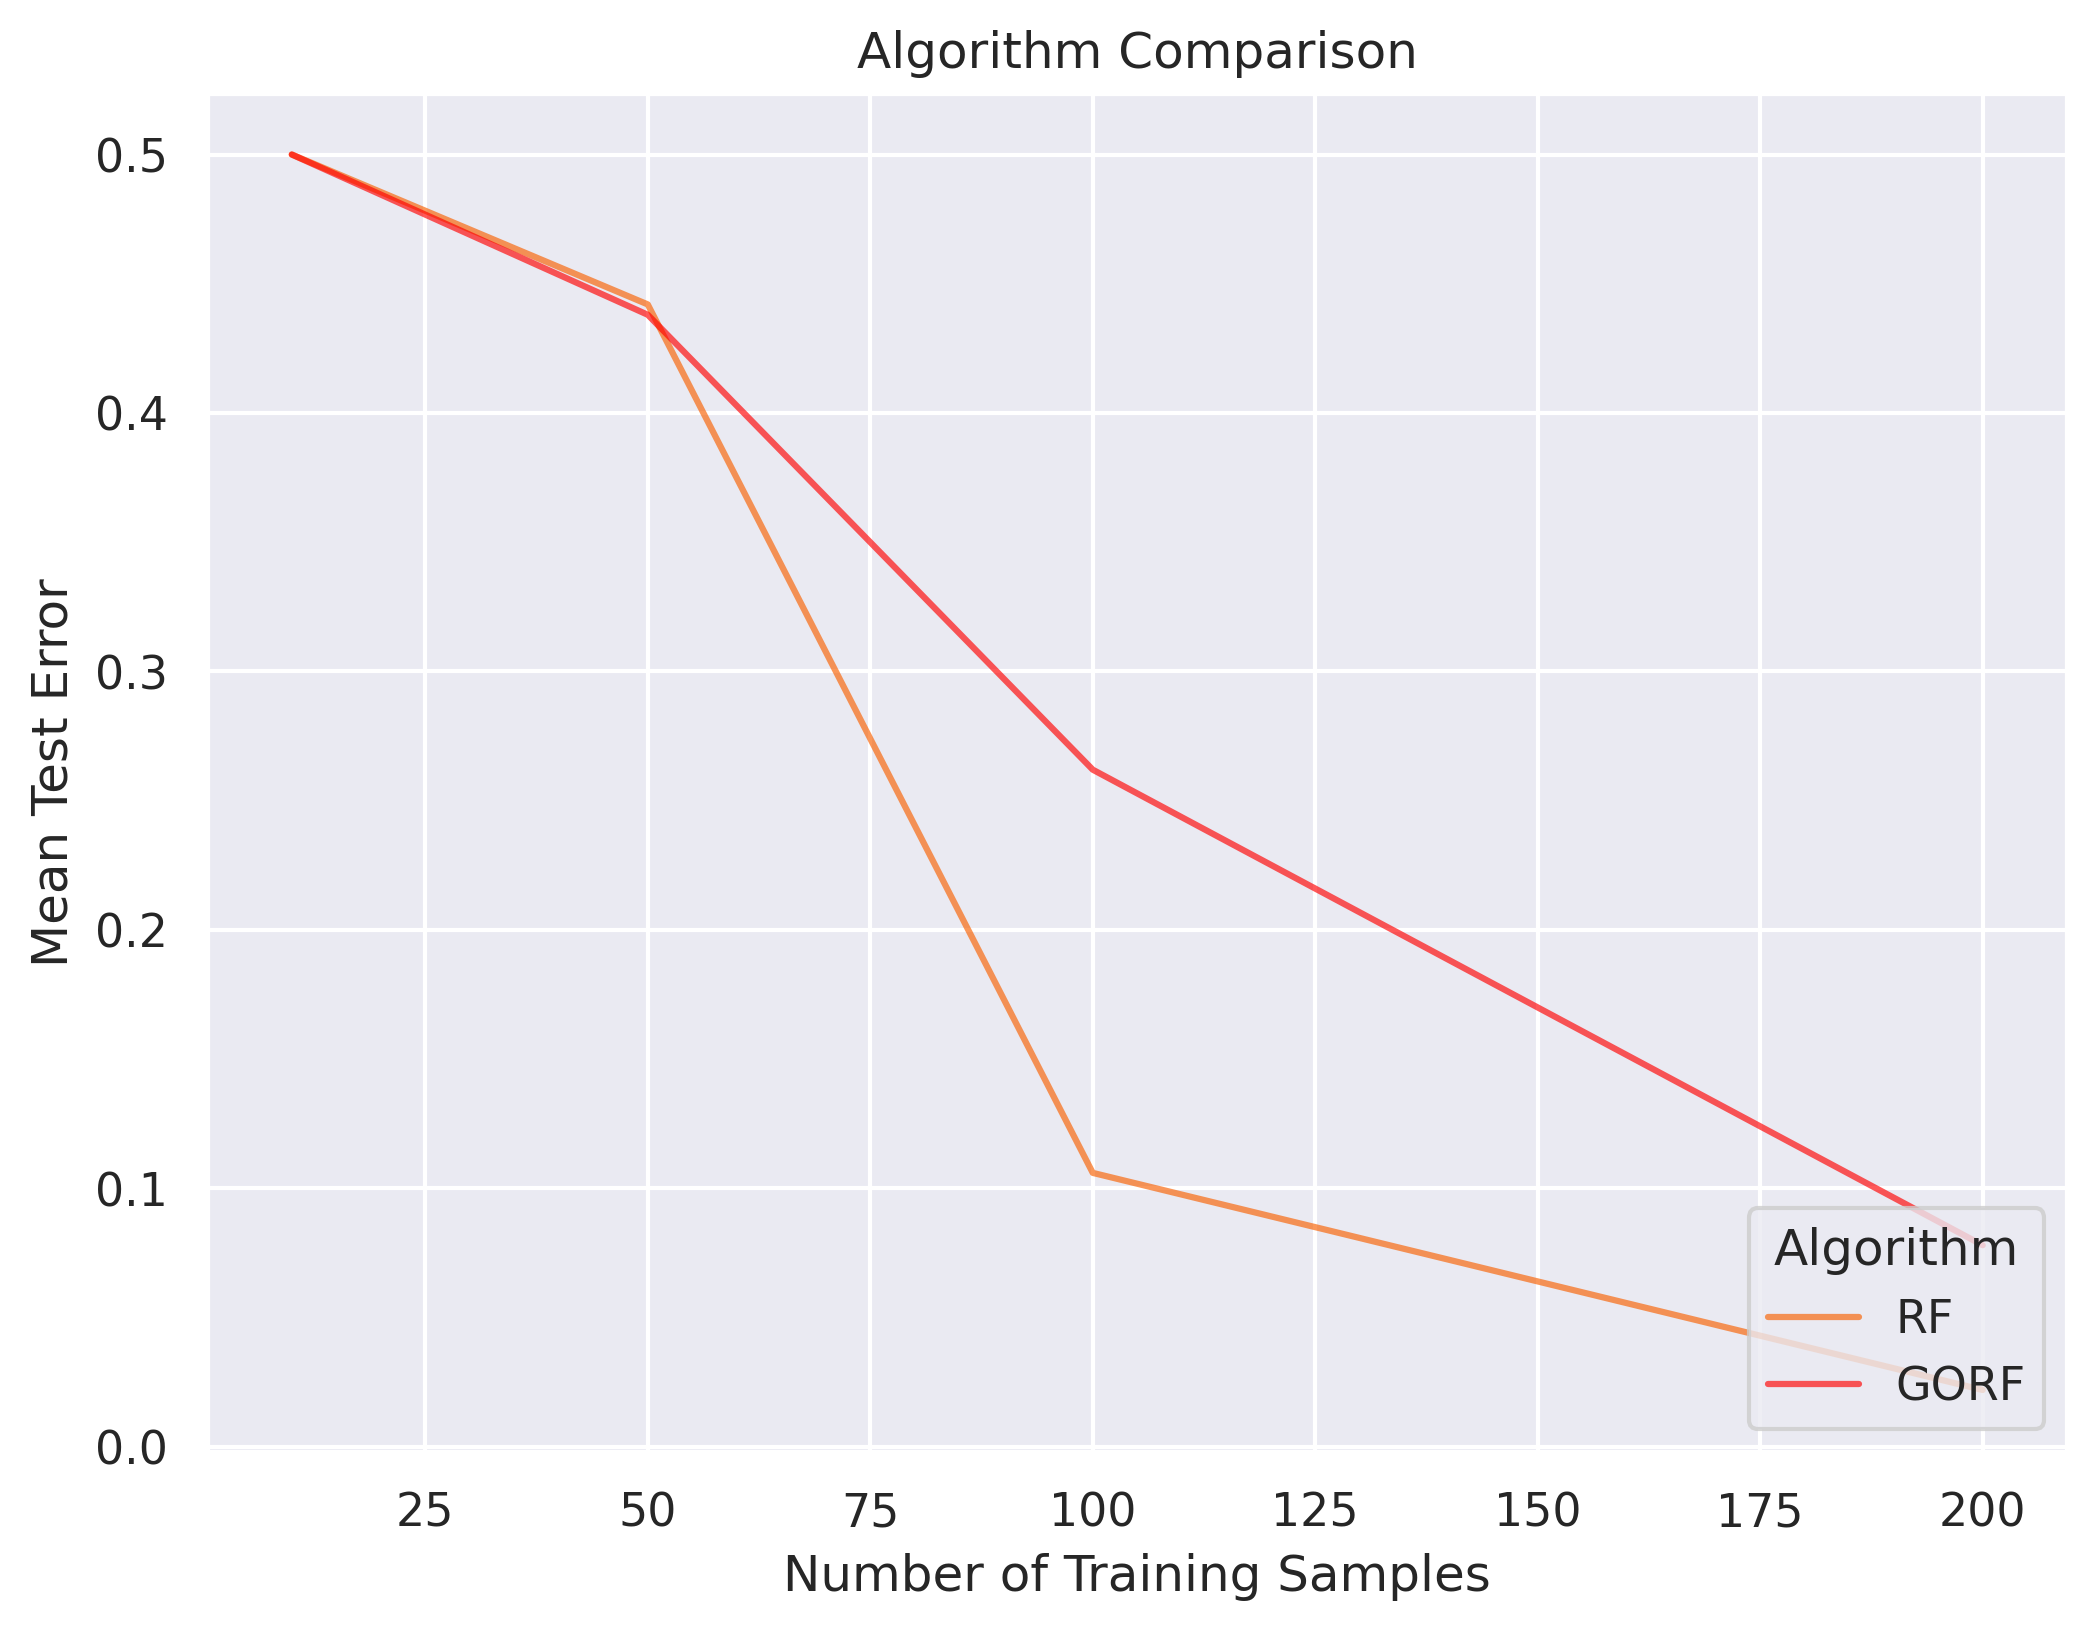

In [69]:
dat = pd.DataFrame(run_data, columns =['classifier','n','Lhat','trainTime','testTime']) 
d1 = pd.DataFrame(columns = ['classifier', 'n', 'Lhat', 'color'])

k = 0
for ni in np.unique(dat['n']):
    for cl in np.unique(dat['classifier']):

        tmp = dat[np.logical_and(dat['classifier'] == cl,dat['n'] == ni)][['n', 'Lhat']]

        se = stats.sem(tmp['Lhat'])

        list(tmp.mean())
        d1.loc[k] = [cl] + list(tmp.mean()) + [names[cl]]
        k += 1


sns.set(style="darkgrid", rc={'figure.figsize':[12,8], 'figure.dpi': 300})
fig, ax = plt.subplots(figsize = (8,6))

for key in names.keys():
    grp = d1[d1['classifier'] == key]
    ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
            c = names[key], alpha =0.65)
    #ax.set_yscale('log')

plt.legend(loc='lower right',title='Algorithm')
plt.title('Algorithm Comparison')
plt.ylabel('Mean Test Error')
plt.xlabel('Number of Training Samples')
plt.show()